# ELECTIVA BASES DE DATOS II - Taller Final

**Grupo:** *Juan Pablo Botina - Santiago Pinchao*

## Métodos auxiliares

In [0]:
!pip install requests pandas numpy seaborn matplotlib ftfy nltk sklearn geopy

import sys
import os
import imp
import requests
from ftfy import fix_encoding


def import_cdn(uri, name=None):
    if not name:
      name = os.path.basename(uri).lower().rstrip('.py')

    r = requests.get(uri)
    r.raise_for_status()

    codeobj = compile(r.content, uri, 'exec')
    module = imp.new_module(name)
    exec (codeobj, module.__dict__)
    return module

aux_tools_code_url = "https://gitlab.com/xCast/python-modules-for-colab/raw/master/aux_tools.py"
str_tools_code_url = "https://gitlab.com/xCast/python-modules-for-colab/raw/master/str_tools.py"

tools = import_cdn(aux_tools_code_url)
str_tools = import_cdn(str_tools_code_url)

     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for ftfy: filename=ftfy-5.6-cp36-none-any.whl size=44552 sha256=26e437c19f7ea13308a5829614626c77e0550ed14666405df860b542a6bed7d9
  Stored in directory: /root/.cache/pip/wheels/43/34/ce/cbb38d71543c408de56f3c5e26ce8ba495a0fa5a28eaaf1046
Successfully built ftfy


## Lectura de datos

In [0]:
import pandas as pd
import numpy as np
import io, requests

path_tp_final_clas = "https://gitlab.com/uploads/-/system/personal_snippet/1920289/692bd6776cdc89be52e4c0cea4b10f2a/tpFinal-clasificacion.csv"
path_tp_final_work = "https://gitlab.com/uploads/-/system/personal_snippet/1920289/fb93b3aec1bea400b899216b49d112ec/tpFinal-work.csv"

sw=requests.get(path_tp_final_work).content
sc=requests.get(path_tp_final_clas).content

In [0]:
#dataw=pd.read_csv(io.StringIO(sw.decode('utf-8')))
#datac=pd.read_csv(io.StringIO(sc.decode('utf-8')))

dataw=pd.read_csv(io.StringIO(fix_encoding(sw.decode('ISO-8859-1')))) # tarda más pero soluciona el problema ;D
datac=pd.read_csv(io.StringIO(sc.decode('latin-1')))
# ISO-8859-1 latin-1 utf8

data_aux = dataw
print("Tamaño DataFrame Work: {0}".format(len(dataw)))
print("Tamaño DataFrame Clasificación: {0}".format(len(datac)))

#data.head(5)

Tamaño DataFrame Work: 11250
Tamaño DataFrame Clasificación: 3750


In [0]:
#dataw.columns
#data_des = fix_encoding(dataw.loc[1 , "des"])
dataw["des"] = dataw.apply(lambda fix_des: fix_encoding(fix_des.loc[:, "des"]), axis=1)
#dataw.loc[1, "des"]
#dataw.loc[3,"des"]
#dataw.head(5)

# **Preparación de los datos**

In [0]:
#data_aux['geoname_num'].fillna(value=0,inplace=True)
#dataw.drop(labels=['geoname_num'],axis=1,inplace=True)

data_aux['geoname_num'].fillna(value=0, inplace=True)

print("Conteo datos nulos en work:")
display(data_aux.isnull().sum())

#print("\nConteo datos nulos en clasificación:")
#display(datac.isnull().sum())

Conteo datos nulos en work:


ident          0
fecha          0
anio           0
mes            0
tipoprop       0
lugar          0
geoname_num    0
sup_tot_m2     0
sup_cub_m2     0
piso           0
cant_amb       0
des            0
tit            0
Clase          0
lat            0
lon            0
dtype: int64

In [0]:
# Cambio fecha string a long
data_aux['fecha'] = dataw.apply(lambda row: tools.str_to_date_long(row['fecha'],"%d/%m/%Y"),axis=1)

In [0]:
# Completado de Latitud y Longitud
print("Conteo datos nulos antes:",data_aux['lat_lon'].isnull().sum())

places_dict = {}
def assign_to_dic(place,coords): places_dict[place] = coords

dataw.apply(lambda dtf: assign_to_dic(dtf['lugar'],dtf['lat_lon']),axis=1)
#print("Diccionario (con valores únicos) de las coordenadas por lugar:",places_dict)

data_aux['lat_lon'] = dataw.apply(
    lambda row: places_dict[row['lugar']] if str(row['lat_lon']) in ['nan','NaN','',' '] else row['lat_lon'],
    axis=1
)

"""
  Después de aplicar esto quedan 8 filas con datos faltantes, esto ocurre porque
  tal ves esas filas tenían lugares que no aparecían en otras filas, por ejemplo
  hay un lugar llamado 'Caballito' que no está en el diccionario.
  Como estos valores son muy pocos en comparación a los que sí se pudieron imputar
  se toma un valor por defecto para ellos.
"""

print("Conteo datos nulos después de imputación:",data_aux['lat_lon'].isnull().sum())
data_aux['lat_lon'].fillna(value='-34.5736905,-58.4717799',inplace=True)
print("Conteo datos nulos después de 'poner por defecto':",data_aux['lat_lon'].isnull().sum())

Conteo datos nulos antes: 365
Conteo datos nulos después de imputación: 8
Conteo datos nulos después de 'poner por defecto': 0


In [0]:
# Separación de latitud y longitud
data_aux["lat"] = dataw["lat_lon"].str.split(",",n=1,expand=True)[0]
data_aux["lon"] = dataw["lat_lon"].str.split(",",n=1,expand=True)[1]
data_aux.drop(columns=['lat_lon'],inplace=True)

In [0]:
data_aux['lon'] = data_aux.lon.astype('float64')
data_aux['lat'] = data_aux.lat.astype('float64')

In [0]:
data_aux.head(5)

ident          fecha  anio  ... Clase        lat        lon
0  414.348  1449360000000  2015  ...     3 -34.566213 -58.434498
1  783.160  1430438400000  2015  ...     1 -34.621131 -58.408298
2  503.648  1429142400000  2015  ...     3 -34.556886 -58.452809
3  851.301  1446768000000  2015  ...     5 -34.589074 -58.403844
4  894.907  1447891200000  2015  ...     1 -34.623335 -58.374838

[5 rows x 16 columns]

In [0]:
data_aux.loc[1,"des"]

'Mariano Aufseher  CUCICBA 4251Contacto: Diego AgÃ¼ero  MLS ID # 42025105513IMPECABLE DEPARTAMENTO DE 2 AMBIENTES AL FRENTE. CON EXCELENTE LUMINOSIDAD, MUY BUENA VISTA.SEGUNDO PISO POR ESCALERA. LIVING, COCINA SEPARADA, BAÃ‘O COMPLETO, DORMITORIO CON PLACA'

In [0]:
import re
# Cantidad de ambientes (96% de los casos esta en la descripcion)
print("Conteo datos nulos antes:",data_aux['cant_amb'].isnull().sum())

def search_ambients(text,default_val):
  regex = "(\d)\s*((ambiente|AMBIENTE)+s*|S*)"
  res = re.findall(regex,text)
  if len(res)!=0:
    return int(res[0][0])
  else:
    return default_val

data_aux['cant_amb'] = dataw.apply(
    lambda row: search_ambients(str(row['des']),row['cant_amb']),
    axis=1
)

print("Conteo datos nulos después:",data_aux['cant_amb'].isnull().sum())
data_aux['cant_amb'].fillna(value=0,inplace=True)
print("Conteo datos nulos después de 'valor por defecto':",data_aux['cant_amb'].isnull().sum())

Conteo datos nulos antes: 2883
Conteo datos nulos después: 124
Conteo datos nulos después de 'valor por defecto': 0


In [0]:
# Piso (se pasan todos los valores invalidos a numericos)
#data_aux['piso'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

data_aux['piso'].fillna(value=0,inplace=True)

In [0]:
# IMPORTANTE!!!
# Este es un enfoque, CAMBIAR si performance es baja

# sup_tot_m2: Al estar relacionada con sup_cub_m2 se imputarán entre sí
data_aux['sup_tot_m2'].fillna(data_aux['sup_cub_m2'],inplace=True)
data_aux['sup_cub_m2'].fillna(data_aux['sup_tot_m2'],inplace=True)
# Como los valores nulos restantes son pocos, se colocarán en ceros
data_aux['sup_tot_m2'].fillna(value=0,inplace=True)
data_aux['sup_cub_m2'].fillna(value=0,inplace=True)

In [0]:
# Titulo: Valor basado en información de otra columna
# https://es.wikipedia.org/wiki/Propiedad_horizontal

#print("Tipos de inmueble:",data_aux['tipoprop'].unique())
types = {'dto':'Departamento','PH':'Propiedad Horizontal','casa':'Casa','local':'Local'}
invalids = ['','nan','NaN','NA',' ']
data_aux['tit'] = data_aux.apply(
    lambda row: types[row['tipoprop']] +" en "+row['lugar'] if str(row['tit']) in invalids else row['tit'],
    axis=1)

In [0]:
# Descripción: Valor basado en información de otras columnas
data_aux.des = data_aux['des'].astype(str)
data_aux['des'] = data_aux.apply(
    lambda row: types[row['tipoprop']] +" en "+row['lugar'] if str(row['des']) in invalids else row['des'],
    axis=1)

In [0]:
data_aux['des'] = data_aux.apply(lambda row: fix_encoding(row['des']),axis=1)

In [0]:
data_aux['des'] = data_aux['des'].apply(str_tools.brute_force_unicode)

In [0]:
data_aux['tit'] = data_aux.apply(lambda row: fix_encoding(row['tit']),axis=1)

In [0]:
data_aux['tit'] = data_aux['tit'].apply(str_tools.brute_force_unicode)

In [0]:
data_aux.loc[3,"des"]

'MUY BUEN DEPARTAMENTO DE 3 AMBIENTES AL FRENTE CON BALCÓN, BAULERA Y COCHERA. 60 m2 TOTALES. LUMINOSO. MUY BUEN ESTADO, PISOS DE PARQUET, AMPLIOS PLACARES (14 PUERTAS), COCINA CON LAVADERO INDEPENDIENTE, BAÑO COMPLETO Y CALEFACCIÓN POR LOSA RADIANTE CE'

##### EXPERIMENTAL

In [0]:
# data_aux.drop(['piso_original'],axis=1,inplace=True)
# data_aux

data_aux.rename(columns={'piso': 'piso_original'})
data_aux.piso_original.max()

20.0

In [0]:
# EXPERIMENTAL
import random

#data_piso = data_aux.rename(columns={'piso': 'piso_original'})
data_piso = data_aux

#data_piso.piso_original.fillna(random.randint(0,12), inplace=True)

def piso_value(piso):
  if piso > 20:
    return random.randint(0,20)
  else:
    return piso

#data_piso['pisito'] = data_piso.apply(lambda piso: piso_value(piso['piso']),axis=1)

#data_piso.insert(9,'piso_original',data_piso['pisito'])

data_piso.drop(['pisito'], axis=1, inplace=True)
data_piso
#X_test.insert(4762,'lugar_Catalinas',0)

## Datos extra (Estaciones subte)

In [0]:
df_estaciones=pd.read_csv("/content/sample_data/subte_stations.csv",sep=",")
df_estaciones

long        lat  ... escaleras_mecanicas ascensores
0  -58.436429 -34.618280  ...                   2          2
1  -58.456710 -34.626667  ...                   3          3
2  -58.421816 -34.611770  ...                   1          1
3  -58.392669 -34.609226  ...                   2          2
4  -58.382232 -34.609100  ...                   1          0
..        ...        ...  ...                 ...        ...
88 -58.397216 -34.587462  ...                   6          4
89 -58.406036 -34.608935  ...                  10          3
90 -58.405795 -34.638406  ...                   4          3
91 -58.402376 -34.594525  ...                   9          7
92 -58.404732 -34.615242  ...                   4          3

[93 rows x 6 columns]

In [0]:
df_complete['distancia_subte_cercana']=0
import geopy.distance
for index, local in df_complete.iterrows():
  distancias=[]
  for index1, estacion in df_estaciones.iterrows():
    distancias.append(geopy.distance.vincenty((local.lat, local.lon), (estacion.lat, estacion.long)).km) 
  df_complete.loc[index, 'distancia_subte_cercana'] = min(distancias)

df_complete.distancia_subte_cercana.min()

In [0]:
df_complete = data_aux
df_complete['distancia_subte_cercana']=0
import geopy.distance
for index, local in df_complete.iterrows():
  distancias=[]
  for index1, estacion in df_estaciones.iterrows():
    distancias.append(geopy.distance.vincenty((local.lat, local.lon), (estacion.lat, estacion.long)).km) 
  df_complete.loc[index, 'distancia_subte_cercana'] = min(distancias)

df_complete.distancia_subte_cercana.min()

0.0019400217592705467

In [0]:
df_complete.head(5),
df_complete.distancia_subte_cercana.min()

0.0019400217592705467

## Exportación de datos

In [0]:
data_aux.to_csv(r'./clean_df.csv', encoding='utf-8',index=False)

In [0]:
df_complete.to_csv(r'./clean_df_complete.csv', encoding='utf-8',index=False)

## Correlación de Variables

In [0]:
data_aux.drop(labels=['Clase'],axis=1,inplace=True)
corr = data_aux.corr()
print("Matriz Correlacion:")
display(corr)

Matriz Correlacion:


ident     fecha      anio  geoname_num  sup_tot_m2  \
ident        1.000000  0.008570  0.008622     0.004161   -0.015373   
fecha        0.008570  1.000000  0.853904     0.024869   -0.071627   
anio         0.008622  0.853904  1.000000     0.028317   -0.063543   
geoname_num  0.004161  0.024869  0.028317     1.000000    0.009885   
sup_tot_m2  -0.015373 -0.071627 -0.063543     0.009885    1.000000   
sup_cub_m2   0.001651 -0.057030 -0.045412    -0.001412    0.627321   
piso         0.004307  0.008749  0.014280    -0.012611   -0.007596   
cant_amb    -0.001910  0.040281  0.035071     0.047769    0.033142   
lat         -0.014505  0.000567 -0.005102    -0.009520    0.001208   
lon         -0.010651 -0.021738 -0.013490     0.018714   -0.005921   

             sup_cub_m2      piso  cant_amb       lat       lon  
ident          0.001651  0.004307 -0.001910 -0.014505 -0.010651  
fecha         -0.057030  0.008749  0.040281  0.000567 -0.021738  
anio          -0.045412  0.014280  0.035071 -0.005102 -0.013490  
geoname_num   -0.001412 -0.012611  0.047769 -0.009520  0.018714  
sup_tot_m2     0.627321 -0.007596  0.033142  0.001208 -0.005921  
sup_cub_m2     1.000000 -0.004111  0.022536 -0.002303 -0.000280  
piso          -0.004111  1.000000  0.027347 -0.000528  0.000769  
cant_amb       0.022536  0.027347  1.000000 -0.005589 -0.019460  
lat           -0.002303 -0.000528 -0.005589  1.000000 -0.078648  
lon           -0.000280  0.000769 -0.019460 -0.078648  1.000000

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

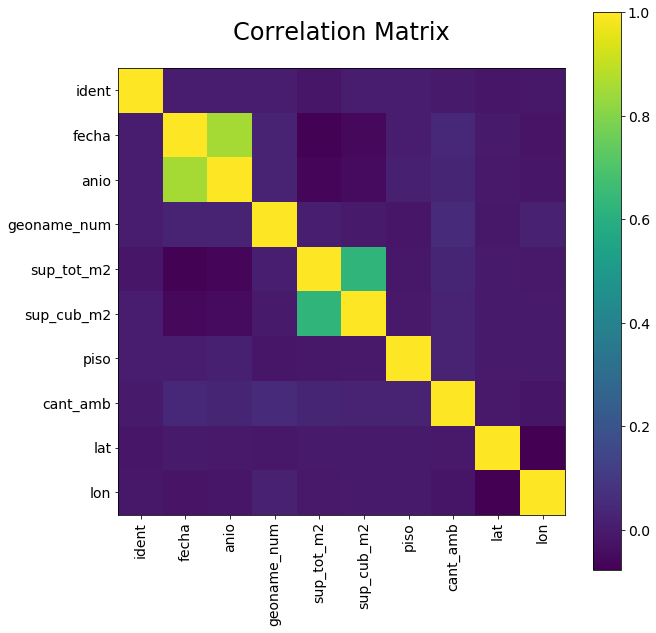

In [0]:
f = plt.figure(figsize=(10, 10))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=90)
plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=24);
